# Introduction to Machine Learning - PROJECT

Authors: Aino Liukkonen and Raúl Cruz-Oliver

This is the course project of the course Introduction to Machine Learning. In this project, we 

### <font color='red'> THIS TWO FOLLOWING CELLS MUST BE RUN BEFORE THE SUBSEQUENT BLOCKS </font> 

*One can go directly to the preprocessing data subsection.* <br>
*No need to execute the example.*

In [506]:
%reset -f

import pandas as pd
# Documentation
# https://pandas.pydata.org/docs

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from sklearn import model_selection
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from mlxtend.feature_selection import SequentialFeatureSelector as sfs #just commented because i dont have the library installed
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import statsmodels.api as sm
import itertools
%matplotlib inline
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.utils import resample

# Our respective DATA folder paths
#data_folder = r'C:\Users\lenovo\Desktop\S7-DE\Introduction to Machine Learning\machine_learning_project\DATA'
data_folder = r'C:\Users\ainol\OneDrive\Tiedostot\TutaJaOhtu\Machine_Learning\course_project\DATA'

In [497]:
# logistic training coded manually. 
# gradient descent used as optimization technique 

#INCLUDE A PROPER DESCRIPTION OF THE AGLORITHM AND THE SOLVING TECNIQUE PROCEDURES

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def logistic_train(theta,X,y):   
    epsilon=1.0E-03
    alpha=0.1
    diff=epsilon+1
    theta_old=theta
    c=0
    sh=np.shape(X)
    m=sh[0] #number of observations in the training data
    while diff > epsilon:
        theta_old=theta
        error=sigmoid(np.dot(X,theta))-y
        theta = theta_old - (alpha/m)*np.dot(np.transpose(X),error)
        diff = np.linalg.norm(theta_old-theta)
        c=c+1
        if c == 10000:
            print ('Max iteration reached')
            return theta
    return theta

## 0. TEST EXAMPLE

F-measure: 1.0
Kappa: 1.0
AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        11

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19



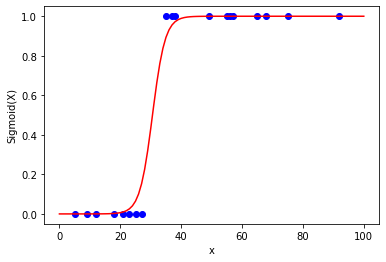

In [50]:
# Import Data
test = pd.read_excel(data_folder + r'\test.xlsx') #once we define the folder, the path is the same
k = 1   #number of predictors, remember theta_0 is for the bias since x_o is always 1
x = test["Age"].array
y = test["Children"].array

# Data preprocessing
sh=np.shape(x)
m=sh[0] #number of observations in the training data

x = x.reshape(-1, 1) 
y = y.reshape(-1, 1) 
ones = np.ones ((m,1)) #for the bias x_0
X = np.concatenate((ones,x),axis=1) #matrix of training data
theta = np.random.rand(k+1,1)

#call to the training function
theta=logistic_train(theta,X,y) 


#trained model visualization
x_graph = np.linspace(0, 100, 101)
x_graph=np.reshape(x_graph, (101,1)) #predictors
ones = np.ones ((101,1)) #for the bias x_0
X_graph = np.concatenate((ones,x_graph),axis=1) #matrix of training data

z_graph = sigmoid(np.dot(X_graph,theta))

plt.plot(x_graph, z_graph, c="red")
plt.xlabel("x")
plt.ylabel("Sigmoid(X)")
x = test["Age"].to_numpy()
y = test["Children"].to_numpy()
plt.scatter(x, y, c="blue")

# Actual class prediction
threshold = 0.5 #limit where sth is clasify as 1 and not anymore as 0
y_predict = sigmoid(np.dot(X,theta))
y_p = np.zeros(m)
for i in range(1,m):
    if y_predict[i]>threshold:
        y_p[i]=1
#y_p contains the final label assignment  

#EVALUATING THE MODEL
#F-MEASURE
print("F-measure:" , metrics.f1_score(y,y_p))
#the closer to 1, the better the performance is
#K-STATISTIC
print("Kappa:",metrics.cohen_kappa_score(y, y_p))
#the closer to 1, the better the performance is
#AREA UNDER CURVE (AUC), FROM RECEIVING OPERATION CHARACTERISTIC (ROC)
print("AUC:",metrics.roc_auc_score(y,y_p))
# if AUC>0.5 it means the classificator is better than a random process. Perfect classificator <=> AUC=1
#other metrics
print(metrics.classification_report(y,y_p))

## 1. ACTUAL DATA IMPORT AND PREPROCESS
Understand dataset and business problem from Cowden et al. (2019).

The data is clearly imbalanced. Thus, several strategies are applied: <br>
    1. Data set only with the original samples (4793 observations: 969 LOSS, 3824 PAY) (Name: pay_loss) <br>
        1a. Using the data as it wasn't imbalance <br>
        1b. Implement stratified split strategies <br>
    2. Undersampling the majority class (1938 observations: 969 LOSS, 969 PAY) (Name: pay_loss_undersampled)<br>
    3. Oversampling the minority class (7648 observations: 3824 LOSS, 3824 PAY) (Name: pay_loss_oversampled)<br>
    4. Generating syntethic samples (Name: pay_loss_synthetic) <br>
    

In [510]:
#DATA READING

# Read data from LOSS.mat
mat_loss = loadmat(data_folder + r'\LOSS.mat')
loss_matrix = mat_loss['LOSS']
loss_matrix = np.matrix(loss_matrix)
#select only the first  rows
#loss_matrix = loss_matrix[0:900,:] #in case we dont wanna use the whole set
# Convert into a Pandas Data Frame
loss = pd.DataFrame(loss_matrix, columns=['NOI', 'DSCR', 'LTV', 'Balance', 
                                        'Rate', 'Fee','Net_Mortgage_Rate', 'Year_Built', 
                                        'Renovation','Occupancy', 'ZipPop', 'CR', 'CS', 
                                        'CS_Ratio','NOI_Ratio', 'PV_Ratio', 'IR'])

# Read data from PAY.mat
mat_pay = loadmat(data_folder + r'\PAY.mat')
pay_matrix = mat_pay['PAY']
pay_matrix = np.matrix(pay_matrix)
#select only the first rows
#pay_matrix = pay_matrix[0:900,:] #in case we dont wanna use the whole set
# Convert into a Pandas Data Frame
pay = pd.DataFrame(pay_matrix, columns=['NOI', 'DSCR', 'LTV', 'Balance', 
                                        'Rate', 'Fee','Net_Mortgage_Rate', 'Year_Built', 
                                        'Renovation','Occupancy', 'ZipPop', 'CR', 'CS', 
                                        'CS_Ratio','NOI_Ratio', 'PV_Ratio', 'IR'])


#LABELLING 
# the value of the column represents whether the mortgage has been paid back or defaulted
loss['is_paid'] = 0
pay['is_paid'] = 1


# Concatenate pay and loss data into one DataFrame
data_frames = [pay, loss]
pay_loss_not_stand = pd.concat(data_frames) #used for the plots


#DATA STANDARIZATION
scaler = StandardScaler()
pay_loss_standarized = scaler.fit_transform(pay_loss_not_stand) 

pay_loss_STAND = pd.DataFrame(pay_loss_standarized, columns=['NOI', 'DSCR', 'LTV', 'Balance', 
                                        'Rate', 'Fee','Net_Mortgage_Rate', 'Year_Built', 
                                        'Renovation','Occupancy', 'ZipPop', 'CR', 'CS', 
                                        'CS_Ratio','NOI_Ratio', 'PV_Ratio', 'IR','is_paid'])

#select the rows according to the standarized labels 
#(remember that the labels now follow a normal distribution centered around 0)
PAY_CORRECT=pay_loss_STAND.is_paid>0
LOSS_CORRECT=pay_loss_STAND.is_paid<0

filtered_PAY = pay_loss_STAND[PAY_CORRECT]
filtered_LOSS = pay_loss_STAND[LOSS_CORRECT]

#relabelling
filtered_PAY.is_paid=1
filtered_LOSS.is_paid=0

data_frames = [filtered_PAY, filtered_LOSS]
pay_loss = pd.concat(data_frames) #concatenated and filtered


#print(pay_loss.shape) 
#17 predictors, 1 label
#4793 observations: 969 LOSS, 3824 PAY

# Separate input features and target
y = pay_loss.is_paid 
X = pay_loss.drop('is_paid', axis=1) 

# setting up testing and training sets, 
# it should be done before any kind of external technique to deal with imbalance, since the way to assess the performance is with actual data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

# concatenate our training data back together
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

#SEVERAL POSIBILITIES FOR THE TRAINING SET

## 1. Imbalance data already stored in pay_loss_imbalanced ##

pay_loss_imbalanced = train  #already suffled due to the spliting for validation

#print(pay_loss_imbalanced.is_paid.value_counts()) #2863 PAY, #731 LOSS

# separate minority and majority classes
loss_train = train[train.is_paid==0] #minority class
pay_train = train[train.is_paid==1]

## 2. Undersampling ##

# downsample majority
pay_train_downsampled = resample(pay_train,
                                replace = False, # sample without replacement
                                n_samples = len(loss_train), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
pay_loss_undersampled = pd.concat([pay_train_downsampled, loss_train])

pay_loss_undersampled = pay_loss_undersampled.sample(frac = 1) #suffle again the data

# checking counts
print (pay_loss_undersampled.is_paid.value_counts()) #731 PAY, #731 LOSS

## 3. Oversampling ##

# upsample minority
loss_train_upsampled = resample(loss_train,
                          replace=True, # sample with replacement
                          n_samples=len(pay_train), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
pay_loss_oversampled = pd.concat([pay_train, loss_train_upsampled])

pay_loss_oversampled = pay_loss_oversampled.sample(frac = 1) #suffle again the data

#print (pay_loss_oversampled.is_paid.value_counts()) #2863 PAY, #2863 LOSS

## 4. Sythetic sampling ## #to be fixed if there is time, shit is happening i dunno where
#from imblearn.over_sampling import SMOTE
#sm = SMOTE(random_state=27, ratio=1.0)
#X_train_syntehtic, y_train_sythetic = sm.fit_sample(X_train, y_train)
#pay_loss_synthetic = pd.concat([X_train, y_train], axis=1)
#print (pay_loss_synthetic.is_paid.value_counts()) #731 PAY, #731 LOSS

#NOTE, how to access the data
#y_train = whatever.is_paid
#X_train = whatever.drop('is_paid', axis=1)

0    731
1    731
Name: is_paid, dtype: int64


c:\Users\ainol\python_virtual_environments\ki\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


## 2. BIVARIATE RELATIONSHIPS BETWEEN VARIABLES (Aino)
We examined the bivariate relationships between 

correlation coeficient: 0.946807249710821


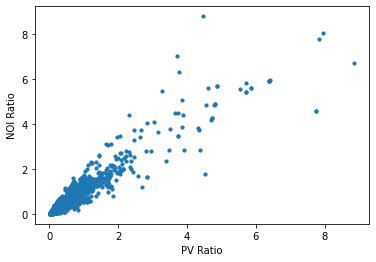

In [499]:
#plt.scatter(pay_loss.Year_Built, pay_loss.IR)
#plt.scatter(pay_loss.ZipPop, pay_loss.CS)
plt.scatter(pay_loss_not_stand.PV_Ratio, pay_loss_not_stand.NOI_Ratio, s=10)
plt.xlabel('PV Ratio')
plt.ylabel('NOI Ratio')

print ('correlation coeficient:',np.corrcoef(pay_loss_not_stand.PV_Ratio, pay_loss_not_stand.NOI_Ratio)[1,0])


correlation coeficient: 0.962149426785957


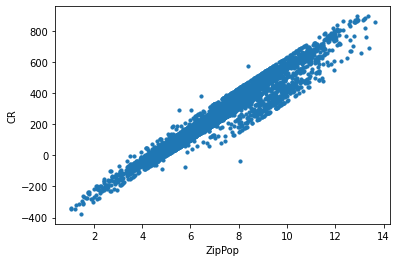

In [500]:
plt.scatter(pay_loss_not_stand.ZipPop, pay_loss_not_stand.CR, s=10)
plt.xlabel('ZipPop')
plt.ylabel('CR')
print ('correlation coeficient:',np.corrcoef(pay_loss_not_stand.ZipPop, pay_loss_not_stand.CR)[1,0])

correlation coeficient: 0.9049789086460073


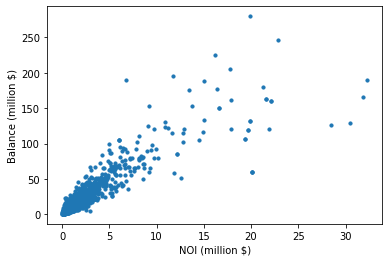

In [501]:
plt.scatter(pay_loss_not_stand.NOI / 10 ** 6 , pay_loss_not_stand.Balance / 10 ** 6, s=10)
plt.xlabel('NOI (million $)')
plt.ylabel('Balance (million $)')
# plt.scatter(pay_loss.NOI, pay_loss.NOI_Ratio) <--- obviously correlated
# plt.scatter(pay_loss.Balance, pay_loss.NOI_Ratio) <--- also obviously correlated

print ('correlation coeficient:',np.corrcoef(pay_loss_not_stand.NOI, pay_loss_not_stand.Balance)[1,0])

correlation coeficient: 0.9385681237192982


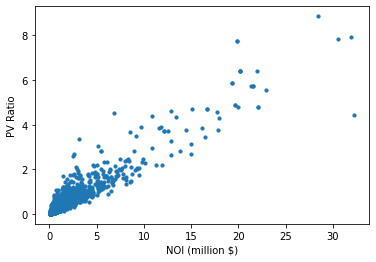

In [502]:
plt.scatter(pay_loss_not_stand.NOI / 10 ** 6 , pay_loss_not_stand.PV_Ratio, s=10)
plt.xlabel('NOI (million $)')
plt.ylabel('PV Ratio')
# --> plt.scatter(pay_loss.Balance, pay_loss.PV_Ratio)  
# and plt.scatter(pay_loss.PV_Ratio, pay_loss.NOI_Ratio) also correlated

print ('correlation coeficient:',np.corrcoef(pay_loss_not_stand.NOI, pay_loss_not_stand.PV_Ratio)[1,0])

correlation coeficient: 0.9939671063692783


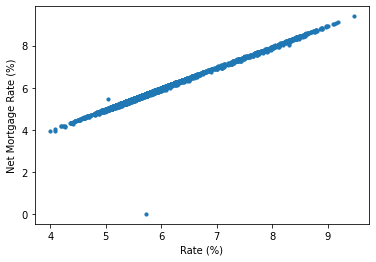

In [503]:
plt.scatter(pay_loss_not_stand.Rate, pay_loss_not_stand.Net_Mortgage_Rate, s=10)
plt.xlabel('Rate (%)')
plt.ylabel('Net Mortgage Rate (%)')

print ('correlation coeficient:',np.corrcoef(pay_loss_not_stand.Rate, pay_loss_not_stand.Net_Mortgage_Rate)[1,0])

## 3. SELECTION OF THE MOST RELEVANT VARIABLES (Aino + revision by Raúl)

This information may be relevant
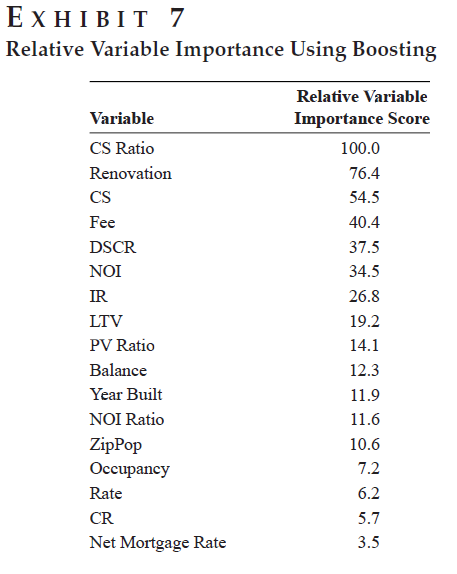 

## Forward and Backward Stepwise Regression

These need some adjusting, and I haven't quite figured out yet why my custom-made function selects different columns in
backward selection than SequentialFeatureSelection. (Related to the use of random forest classifier with SequentialFeatureSelection?)

In [516]:
# Forward stepwise selection
svm = SVC()

SFS = pay_loss_oversampled
y_train_SFS = SFS.is_paid
X_train_SFS = SFS.drop('is_paid', axis=1)

forward_feature_selection = sfs(svm,
                                forward=True,
                                floating=False,
                                verbose=2,
                                scoring='accuracy',
                                k_features=17,
                                cv=5)

forward_feature_selection = forward_feature_selection.fit(X_train_SFS, y_train_SFS)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:  2.0min finished

[2022-03-03 01:45:42] Features: 1/17 -- score: 0.5960529504561147[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:  1.6min finished

[2022-03-03 01:47:20] Features: 2/17 -- score: 0.6313311537377017[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.4min finished

[2022-03-03 01:48:42] Features: 3/17 -- score: 0.6411091550637493[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [517]:
# Backward stepwise Regression
svm = SVC()

backward_feature_selection = sfs(svm,
                                forward=False,
                                floating=False,
                                verbose=2,
                                scoring='accuracy',
                                cv=5)

backward_feature_selection = backward_feature_selection.fit(X_train_SFS, y_train_SFS)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:  1.8min finished

[2022-03-03 02:05:04] Features: 16/1 -- score: 0.6996110260103492[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:  1.8min finished

[2022-03-03 02:06:52] Features: 15/1 -- score: 0.7024068527706013[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.7min finished

[2022-03-03 02:08:32] Features: 14/1 -- score: 0.7008354100459544[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

## Best Subset Selection

In [521]:
# Best subset selection for a specific number of predictors k
def get_best(k, X, y):
    results = []

    # For each combination with a specific k value
    for combo in itertools.combinations(X.columns, k):
        svm = SVC()
        model = svm.fit(X[list(combo)], y)
        predY_svm = svm.predict(X[list(combo)])
        # Calculate Accuracy for the model
        acc = metrics.accuracy_score(y, predY_svm)
        results.append({'model':model, 'Accuracy':acc})
        #print(".", end="") # Please ignore, just wanted to see the progress

    models = pd.DataFrame(results)
    # The best model is the one with the biggest AUC
    best_model = models.loc[models['Accuracy'].argmax()]

    return best_model

In [522]:
best = pay_loss_oversampled
y_train_best = best.is_paid
X_train_best = best.drop('is_paid', axis=1)

# Call the get_best() function for each number of predictors k
best_models = pd.DataFrame(columns = ['model', 'Accuracy'])
for i in range(1, 18):
    print("\n",i)
    best_models.loc[i] = get_best(i, X_train_best, y_train_best)


 1

 2


## 4. COMPARISON AMONG MODELS

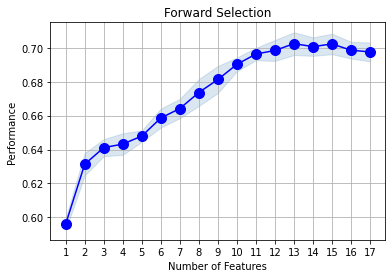

In [518]:
fig = plot_sfs(forward_feature_selection.get_metric_dict(), kind='std_err')
plt.title('Forward Selection')
plt.grid()
plt.show()

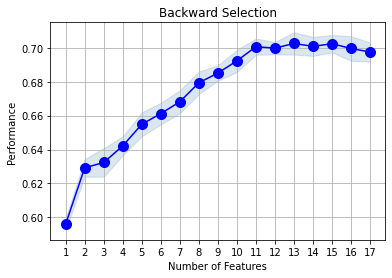

In [519]:
fig = plot_sfs(backward_feature_selection.get_metric_dict(), kind='std_err')
plt.title('Backward Selection')
plt.grid()
plt.show()

## 5. IMPLEMENTATION OF THE LOGISTIC REGRESSION WITH THE ACTUAL DATA. (Raúl)
All predictors (k=17)

5726 samples are being considered for the training
The model offers a AUC based on the training data : 0.6917307663016161
Testing the model in the subset reserved for it ->
AUC:  0.6358266511599436
F1:  0.6683544303797467
Accuracy:  56.3 %


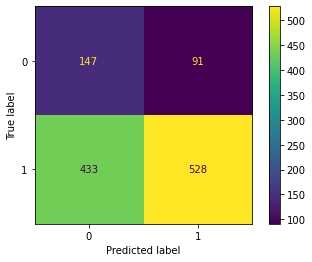

In [112]:
#TRAINING WITH K-FOLD CROSS VALIDATION FOR PARAMETER SELECTION

ManualLogistic = pay_loss_oversampled #select the training data: imbalanced, undersampled, oversampled
ManualLogistic['BIAS']=1 # Adding a column to the DataFrames for the independent bias x_o in the literature. ONLY NEEDED FOR MANUAL LOGISTIC

print(ManualLogistic.shape[0], "samples are being considered for the training")

kf = KFold(n_splits=5)

#print(kf)

#print(kf.split(X))

k=17
threshold = 0.5
AUC=0

y_train_logistic = ManualLogistic.is_paid.to_numpy()
y_train_logistic = y_train_logistic.reshape(-1, 1)    
X_train_logistic = ManualLogistic.drop('is_paid', axis=1).to_numpy()


for train_index, test_index in kf.split(X_train_logistic):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train_folded, X_test_folded = X_train_logistic[train_index], X_train_logistic[test_index]
    y_train_folded, y_test_folded = y_train_logistic[train_index], y_train_logistic[test_index]
    #model training and evaluation for every fold
    theta = np.random.rand(k+1,1)
    theta=logistic_train(theta,X_train_folded,y_train_folded)    
    y_p = sigmoid(np.dot(X_test_folded,theta))
    AUC_current=metrics.roc_auc_score(y_test_folded,y_p) #with the likelihood prediction, not with the final class asignement
    if AUC_current>AUC: #just selecting the best out of the total folds 
        AUC=AUC_current
        theta_out=theta
        
#print(theta_out) #parameters of the model
print("The model offers a AUC based on the training data :",AUC)

print("Testing the model in the subset reserved for it ->")

test['BIAS']=1 #just because of the manual implementation
y_test_logistic = test.is_paid.to_numpy()
y_test_logistic = y_test_logistic.reshape(-1, 1)    
X_test_logistic = test.drop('is_paid', axis=1).to_numpy()


y_p_test = sigmoid(np.dot(X_test_logistic,theta))
h_test=y_p_test.shape[0]
y_pre_test = np.zeros(h_test)

for i in range(0,h_test): 
    if y_p_test[i]>0.5: #the threshold can be changed
        y_pre_test[i]=1    
            
print("AUC: ", metrics.roc_auc_score(y_test_logistic,y_p_test))
print("F1: ", metrics.f1_score(y_test_logistic,y_pre_test))
print("Accuracy: ", round(metrics.accuracy_score(y_test_logistic,y_pre_test)*100,2), "%")

cm = metrics.confusion_matrix(y_test_logistic, y_pre_test)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


## 6. SUPPORT VECTOR MACHINE + TUNING ITS PARAMETERS (Aino, before the 02.03 ev)

I think the only parameter that can be tunned is the kernel being used

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

5726 samples are being considered for the training
1    2863
0    2863
Name: is_paid, dtype: int64
1    961
0    238
Name: is_paid, dtype: int64
F1: 0.7014925373134328
Accuracy:  59.97 %


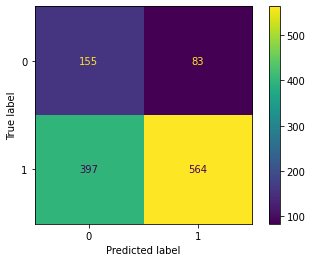

In [520]:
SVM = pay_loss_oversampled #select the training data: imbalanced, undersampled, oversampled

print(SVM.shape[0], "samples are being considered for the training")

print (SVM.is_paid.value_counts())
print (test.is_paid.value_counts())

y_train_SVM = SVM.is_paid
X_train_SVM = SVM.drop('is_paid', axis=1)

#using the same set to evaluate until i manage to tune the parameters somehow, then change to train
y_test_SVM = test.is_paid
X_test_SVM= test.drop('is_paid', axis=1)

svm_model = SVC(kernel='poly', C=1, degree=3, coef0=20)
svm_model.fit(X_train_SVM, y_train_SVM) 

predY_svm_model = svm_model.predict(X_test_SVM)

print('F1:', metrics.f1_score(y_test_SVM,predY_svm_model)) #need label class prediction
print("Accuracy: ", round(metrics.accuracy_score(y_test_SVM,predY_svm_model)*100,2), "%")

cm = metrics.confusion_matrix(y_test_SVM, predY_svm_model)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()




## 7. NEURAL NETWORK + TUNING ITS PARAMETERS (Raúl, before the 02.03 evening)

Parameters subject of study, layers and neurons per layer

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier

5726 samples are being considered for the training
AUC: 0.8096474354712205
F1: 0.7055762081784387
Accuracy: 72.34 %


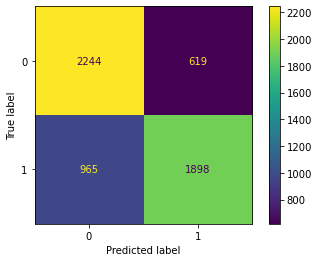

In [151]:
NN = pay_loss_oversampled #select the training data: imbalanced, undersampled, oversampled

print(NN.shape[0], "samples are being considered for the training")

y_train_NN = NN.is_paid
X_train_NN = NN.drop('is_paid', axis=1)

y_test_NN = NN.is_paid
X_test_NN = NN.drop('is_paid', axis=1)


clf = MLPClassifier(hidden_layer_sizes=(10,10,),activation='relu', solver='adam', random_state=1, max_iter=10000).fit(X_train_NN, y_train_NN)

#print(clf.predict(X_test)) #classification result, class depending of which output neuron fires stronger 

#print(clf.predict_proba(X_test)) #output layer, 2 neurons 

y_predict_p=clf.predict_proba(X_test_NN)

#print(y_predict_p[:,1]) #output of the class '1' neuron, ~probability of estimation

print('AUC:', metrics.roc_auc_score(y_test_NN,y_predict_p[:,1])) #need of probability to compute this metric
print('F1:', metrics.f1_score(y_test_NN,clf.predict(X_test_NN))) #need label class prediction
print('Accuracy:', round(clf.score(X_test_NN, y_test_NN)*100,2),"%") #accuracy=correct predictions/total predictions


plot_confusion_matrix(clf, X_test_NN, y_test_NN)  



## 8. AMONG TECHNIQUES COMPARISION (Together on the 02.03 evening)

In [ ]:
Table including the AUC offered by each classificator



## 9. GENERAL CONCLUSION (Together on the 02.03 evening)